In [1]:
import yfinance as yf
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np
import ta
from datetime import datetime, timedelta

# import talib

## 1.1 Get Historical Data from yfinance

In [2]:
# Define the list of stock ticker symbols
stock_symbols = ['SPY', 'QQQ', 'EEM', 'VT', "ESGV", "VSGX", "VTI", "GLD"]
start_date_str = "2020-01-01"
end_date_str = "2023-01-01"

start_date = datetime.strptime(start_date_str, '%Y-%m-%d')  # Convert start_date string to datetime object
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')  # Convert end_date string to datetime object

date_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]


# Retrieve historical data for the stock symbols
data = yf.download(stock_symbols, interval="1d", start=start_date, end=end_date, group_by='ticker')
data

[*********************100%***********************]  8 of 8 completed


VSGX                                                      \
                 Open       High        Low      Close  Adj Close  Volume   
Date                                                                        
2020-01-02  53.939999  54.060001  53.880001  54.060001  50.322071   62700   
2020-01-03  53.520000  53.709999  53.310001  53.349998  49.661156  539200   
2020-01-06  53.200001  53.500000  53.049999  53.500000  49.800785   75300   
2020-01-07  53.389999  53.480000  53.279999  53.349998  49.661156   90200   
2020-01-08  53.299999  53.680000  53.279999  53.509998  49.810097   91000   
...               ...        ...        ...        ...        ...     ...   
2022-12-23  49.080002  49.299999  48.970001  49.250000  49.148151  148800   
2022-12-27  49.320000  49.619999  49.320000  49.470001  49.367699  317600   
2022-12-28  49.450001  49.549999  48.860001  48.860001  48.758961  295000   
2022-12-29  49.320000  49.770000  49.320000  49.709999  49.607201  436500   
2022-12-30  49.320000  49.540001  49.070000  49.189999  49.088276  214500   

                 ESGV                                   ...        EEM  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2020-01-02  56.980000  57.070000  56.689999  57.060001  ...  45.349998   
2020-01-03  56.509998  56.860001  56.500000  56.660000  ...  44.910000   
2020-01-06  56.529999  56.849998  56.250000  56.849998  ...  44.590000   
2020-01-07  56.820000  56.869999  56.639999  56.720001  ...  44.689999   
2020-01-08  56.830002  57.310001  56.730000  57.080002  ...  44.689999   
...               ...        ...        ...        ...  ...        ...   
2022-12-23  65.400002  65.910004  65.099998  65.900002  ...  37.610001   
2022-12-27  65.730003  65.930000  65.239998  65.529999  ...  38.080002   
2022-12-28  65.510002  65.830002  64.699997  64.739998  ...  37.779999   
2022-12-29  65.169998  66.169998  65.169998  66.040001  ...  38.180000   
2022-12-30  65.410004  65.860001  65.129997  65.860001  ...  37.759998   

                                                   QQQ              \
                Close  Adj Close    Volume        Open        High   
Date                                                                 
2020-01-02  45.779999  43.166508  78570100  214.399994  216.160004   
2020-01-03  44.930000  42.365032  78998200  213.300003  215.470001   
2020-01-06  44.820000  42.261311  40085300  212.500000  215.589996   
2020-01-07  44.790001  42.233028  65705300  215.639999  216.139999   
2020-01-08  45.049999  42.478184  86913300  215.500000  218.139999   
...               ...        ...       ...         ...         ...   
2022-12-23  37.799999  37.799999  19543300  265.470001  268.040009   
2022-12-27  38.360001  38.360001  42338900  266.739990  266.850006   
2022-12-28  37.799999  37.799999  31813900  263.170013  265.470001   
2022-12-29  38.430000  38.430000  27088700  262.959991  267.399994   
2022-12-30  37.900002  37.900002  38297800  263.619995  266.410004   

                                                          
                   Low       Close   Adj Close    Volume  
Date                                                      
2020-01-02  213.979996  216.160004  212.012711  30969400  
2020-01-03  213.279999  214.179993  210.070679  27518900  
2020-01-06  212.240005  215.559998  211.424194  21655300  
2020-01-07  214.850006  215.529999  211.394775  22139300  
2020-01-08  215.160004  217.149994  212.983688  26397300  
...                ...         ...         ...       ...  
2022-12-23  263.529999  267.359985  266.946716  39373600  
2022-12-27  263.029999  263.579987  263.172577  38009000  
2022-12-28  259.730011  260.100006  259.697968  47139000  
2022-12-29  262.250000  266.440002  266.028168  45893600  
2022-12-30  262.290009  266.279999  265.868408  37858300  

[756 rows x 48 columns]

In [3]:
data = data.fillna(method="ffill")

## 1.2 Generate trading signals

In [4]:
# Initialize the dataframe to store buy and sell signals
signals_df = pd.DataFrame(columns=['symbol', 'time', 'label', 'units'])

# Calculate indicators and generate signals for each stock
for symbol in stock_symbols:
    df = data[symbol].copy()

    # Calculate moving averages
    df['sma50'] = df['Close'].rolling(window=50).mean()
    df['sma200'] = df['Close'].rolling(window=200).mean()

    # Generate buy and sell signals based on moving average crossing
    df['buy_signal'] = (df['sma50'] > df['sma200']) & (df['sma50'].shift(1) < df['sma200'].shift(1))
    df['sell_signal'] = (df['sma50'] < df['sma200']) & (df['sma50'].shift(1) > df['sma200'].shift(1))
    
    # Additional conditions to make it more sensitive
    df['buy_signal'] |= (df['Close'] < df['sma200'] * 0.90)  # Buy if the price is 5% below the 200MA
    df['sell_signal'] |= (df['Close'] > df['sma200'] * 1.1)  # Sell if the price is 10% above the 200MA

    # Record buy signals to the signals dataframe
    buy_indices = df[df['buy_signal']].index
    buy_data = df.loc[buy_indices, ['Close']]
    buy_data['symbol'] = symbol
    buy_data['time'] = buy_data.index
    buy_data['label'] = 'buy'
    buy_data['units'] = 1
    signals_df = pd.concat([signals_df, buy_data])

    # Record sell signals to the signals dataframe
    sell_indices = df[df['sell_signal']].index
    sell_data = df.loc[sell_indices, ['Close']]
    sell_data['symbol'] = symbol
    sell_data['time'] = sell_data.index
    sell_data['label'] = 'sell'
    sell_data['units'] = -1
    signals_df = pd.concat([signals_df, sell_data])

# Sort the signals dataframe by time
signals_df = signals_df.sort_values('time')

# Print the signals dataframe
signals_df

,symbol,time,label,units,Close
2020-10-15,QQQ,2020-10-15,sell,-1,290.100006
2020-10-15,ESGV,2020-10-15,sell,-1,64.550003
2020-10-15,VTI,2020-10-15,sell,-1,177.869995
2020-10-15,EEM,2020-10-15,sell,-1,45.400002
2020-10-15,SPY,2020-10-15,sell,-1,347.500000
...,...,...,...,...,...
2022-12-23,QQQ,2022-12-23,buy,1,267.359985
2022-12-27,QQQ,2022-12-27,buy,1,263.579987
2022-12-28,QQQ,2022-12-28,buy,1,260.100006
2022-12-29,QQQ,2022-12-29,buy,1,266.440002


In [5]:
print(len(signals_df[signals_df["label"]=="buy"]))
print(len(signals_df[signals_df["label"]=="sell"]))

728
1345


## 2.1 Make holdings dataframe to record holding units over time

In [6]:
# Subtract one day from the date
initial_date = start_date - timedelta(days=1)
holdings_log = pd.DataFrame(index=[initial_date] + date_list, columns=stock_symbols)
holdings_log

,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

initial_holdings = {'SPY': 10, 'QQQ': 5}

initial_cash_balance = 10000

current_holdings = {}

# initialise

holdings_log.loc[initial_date, "cash_balance"] = initial_cash_balance

for stock in stock_symbols:
    if stock in initial_holdings:
        current_holdings[stock] = initial_holdings[stock]
        holdings_log.loc[initial_date, stock] = initial_holdings[stock]
    else:
        holdings_log.loc[initial_date, stock] = 0
        current_holdings[stock] = 0
cash_balance_log = pd.DataFrame(columns=["cash_balance"])

holdings_log

,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD,cash_balance
2019-12-31,10,5,0,0,0,0,0,0,10000.0
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
signals_df

,symbol,time,label,units,Close
2020-10-15,QQQ,2020-10-15,sell,-1,290.100006
2020-10-15,ESGV,2020-10-15,sell,-1,64.550003
2020-10-15,VTI,2020-10-15,sell,-1,177.869995
2020-10-15,EEM,2020-10-15,sell,-1,45.400002
2020-10-15,SPY,2020-10-15,sell,-1,347.500000
...,...,...,...,...,...
2022-12-23,QQQ,2022-12-23,buy,1,267.359985
2022-12-27,QQQ,2022-12-27,buy,1,263.579987
2022-12-28,QQQ,2022-12-28,buy,1,260.100006
2022-12-29,QQQ,2022-12-29,buy,1,266.440002


## 2.2 Reflect holding units based on trading signals

In [9]:
current_cash_balance = initial_cash_balance

# Iterate through trade log dataframe and update current holdings
for index, row in signals_df.iterrows():
    date = index
    stock_ticker = row['symbol']
    action = row['label']
    units = row['units']
    trade_price = units * row["Close"]
    
    if action == 'buy':
        current_holdings[stock_ticker] += units
        current_cash_balance -= trade_price
    elif action == 'sell':
        current_holdings[stock_ticker] -= units
        current_cash_balance += trade_price
        
    holdings_log.loc[date, stock_ticker] = current_holdings[stock_ticker]
    holdings_log.loc[date, "cash_balance"] = current_cash_balance
        
holdings_log


,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD,cash_balance
2019-12-31,10,5,0,0,0,0,0,0,10000.000000
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-28,NaN,367,NaN,NaN,NaN,NaN,NaN,NaN,-353967.119949
2022-12-29,NaN,368,NaN,NaN,NaN,NaN,NaN,NaN,-354233.559952
2022-12-30,NaN,369,NaN,NaN,NaN,NaN,NaN,NaN,-354499.839951
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
holdings_log.index = pd.to_datetime(holdings_log.index)
holdings_log = holdings_log.sort_index()
holdings_log = holdings_log.fillna(method="ffill")
holdings_log

,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD,cash_balance
2019-12-31,10,5,0,0,0,0,0,0,10000.000000
2020-01-01,10,5,0,0,0,0,0,0,10000.000000
2020-01-02,10,5,0,0,0,0,0,0,10000.000000
2020-01-03,10,5,0,0,0,0,0,0,10000.000000
2020-01-04,10,5,0,0,0,0,0,0,10000.000000
...,...,...,...,...,...,...,...,...,...
2022-12-28,289,367,281,251,321,281,283,13,-353967.119949
2022-12-29,289,368,281,251,321,281,283,13,-354233.559952
2022-12-30,289,369,281,251,321,281,283,13,-354499.839951
2022-12-31,289,369,281,251,321,281,283,13,-354499.839951


## 2.3 Calculate total value (cash+equity) at every point.

In [11]:
start_date = holdings_log.index[0]
end_date = holdings_log.index[-1] + timedelta(days=1)

historical_price_data = yf.download(stock_symbols, start=start_date, end=end_date, interval="1d", group_by='ticker')

#historical_price_data = historical_price_data.fillna(method='ffill')
# Retrieve the closing price
historical_price_data

[*********************100%***********************]  8 of 8 completed


VSGX                                                      \
                 Open       High        Low      Close  Adj Close  Volume   
Date                                                                        
2019-12-31  53.369999  53.500000  53.090000  53.459999  49.763554  132500   
2020-01-02  53.939999  54.060001  53.880001  54.060001  50.322067   62700   
2020-01-03  53.520000  53.709999  53.310001  53.349998  49.661156  539200   
2020-01-06  53.200001  53.500000  53.049999  53.500000  49.800793   75300   
2020-01-07  53.389999  53.480000  53.279999  53.349998  49.661156   90200   
...               ...        ...        ...        ...        ...     ...   
2022-12-23  49.080002  49.299999  48.970001  49.250000  49.148151  148800   
2022-12-27  49.320000  49.619999  49.320000  49.470001  49.367699  317600   
2022-12-28  49.450001  49.549999  48.860001  48.860001  48.758961  295000   
2022-12-29  49.320000  49.770000  49.320000  49.709999  49.607201  436500   
2022-12-30  49.320000  49.540001  49.070000  49.189999  49.088276  214500   

                 ESGV                                   ...         VTI  \
                 Open       High        Low      Close  ...         Low   
Date                                                    ...               
2019-12-31  56.360001  56.610001  56.290001  56.570000  ...  162.720001   
2020-01-02  56.980000  57.070000  56.689999  57.060001  ...  163.779999   
2020-01-03  56.509998  56.860001  56.500000  56.660000  ...  163.009995   
2020-01-06  56.529999  56.849998  56.250000  56.849998  ...  162.830002   
2020-01-07  56.820000  56.869999  56.639999  56.720001  ...  163.779999   
...               ...        ...        ...        ...  ...         ...   
2022-12-23  65.400002  65.910004  65.099998  65.900002  ...  189.009995   
2022-12-27  65.730003  65.930000  65.239998  65.529999  ...  189.750000   
2022-12-28  65.510002  65.830002  64.699997  64.739998  ...  188.059998   
2022-12-29  65.169998  66.169998  65.169998  66.040001  ...  189.369995   
2022-12-30  65.410004  65.860001  65.129997  65.860001  ...  189.279999   

                                                    GLD              \
                 Close   Adj Close   Volume        Open        High   
Date                                                                  
2019-12-31  163.619995  155.496552  3262400  143.309998  143.600006   
2020-01-02  164.979996  156.789001  3291100  143.860001  144.210007   
2020-01-03  163.929993  155.791138  3625400  145.750000  146.320007   
2020-01-06  164.490005  156.323364  6813800  148.440002  148.479996   
2020-01-07  164.100006  155.952713  2498400  147.570007  148.139999   
...                ...         ...      ...         ...         ...   
2022-12-23  191.419998  190.652878  4214400  166.880005  167.800003   
2022-12-27  190.619995  189.856079  6037700  167.889999  170.610001   
2022-12-28  188.220001  187.465714  5711900  168.050003  168.339996   
2022-12-29  191.679993  190.911835  5425700  168.539993  169.350006   
2022-12-30  191.190002  190.423798  5979800  169.259995  169.899994   

                                                          
                   Low       Close   Adj Close    Volume  
Date                                                      
2019-12-31  142.800003  142.899994  142.899994   5313500  
2020-01-02  143.399994  143.949997  143.949997   7733800  
2020-01-03  145.399994  145.860001  145.860001  12272800  
2020-01-06  146.949997  147.389999  147.389999  14403300  
2020-01-07  147.429993  147.970001  147.970001   7978500  
...                ...         ...         ...       ...  
2022-12-23  166.660004  167.259995  167.259995   2912300  
2022-12-27  167.800003  168.669998  168.669998   6885700  
2022-12-28  167.100006  167.910004  167.910004   3662500  
2022-12-29  168.520004  168.850006  168.850006   3345900  
2022-12-30  168.800003  169.639999  169.639999   2864500  

[757 rows x 48 columns]

In [12]:
historical_price_data = historical_price_data.fillna(method='ffill')

In [13]:
for index, row in holdings_log.iterrows():
    total_value = row["cash_balance"]
    for stock in stock_symbols:
        try:
            close_price = historical_price_data[stock].loc[index, "Close"]
            
        except:
            continue
        
        total_value += (row[stock] * close_price)
        holdings_log.loc[index, "total_value"] = total_value

In [14]:
holdings_log

,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD,cash_balance,total_value
2019-12-31,10,5,0,0,0,0,0,0,10000.000000,14281.649857
2020-01-01,10,5,0,0,0,0,0,0,10000.000000,NaN
2020-01-02,10,5,0,0,0,0,0,0,10000.000000,14329.499969
2020-01-03,10,5,0,0,0,0,0,0,10000.000000,14295.000000
2020-01-04,10,5,0,0,0,0,0,0,10000.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-28,289,367,281,251,321,281,283,13,-353967.119949,-27683.366680
2022-12-29,289,368,281,251,321,281,283,13,-354233.559952,-21203.619606
2022-12-30,289,369,281,251,321,281,283,13,-354499.839951,-22161.120983
2022-12-31,289,369,281,251,321,281,283,13,-354499.839951,NaN


In [15]:
#plotting wont work with nan values

holdings_log = holdings_log.fillna(method='ffill')
holdings_log

,SPY,QQQ,EEM,VT,ESGV,VSGX,VTI,GLD,cash_balance,total_value
2019-12-31,10,5,0,0,0,0,0,0,10000.000000,14281.649857
2020-01-01,10,5,0,0,0,0,0,0,10000.000000,14281.649857
2020-01-02,10,5,0,0,0,0,0,0,10000.000000,14329.499969
2020-01-03,10,5,0,0,0,0,0,0,10000.000000,14295.000000
2020-01-04,10,5,0,0,0,0,0,0,10000.000000,14295.000000
...,...,...,...,...,...,...,...,...,...,...
2022-12-28,289,367,281,251,321,281,283,13,-353967.119949,-27683.366680
2022-12-29,289,368,281,251,321,281,283,13,-354233.559952,-21203.619606
2022-12-30,289,369,281,251,321,281,283,13,-354499.839951,-22161.120983
2022-12-31,289,369,281,251,321,281,283,13,-354499.839951,-22161.120983


In [16]:
# Check dimensions. indices must be one-dimensional for plotting

print(holdings_log.index.nlevels)
print(holdings_log.columns.nlevels)
print(holdings_log.isnull().sum().sum())

1
1
0


In [17]:
holdings_log.to_csv("holdings_log.csv")

## 3.1 Plot portfolio value over time

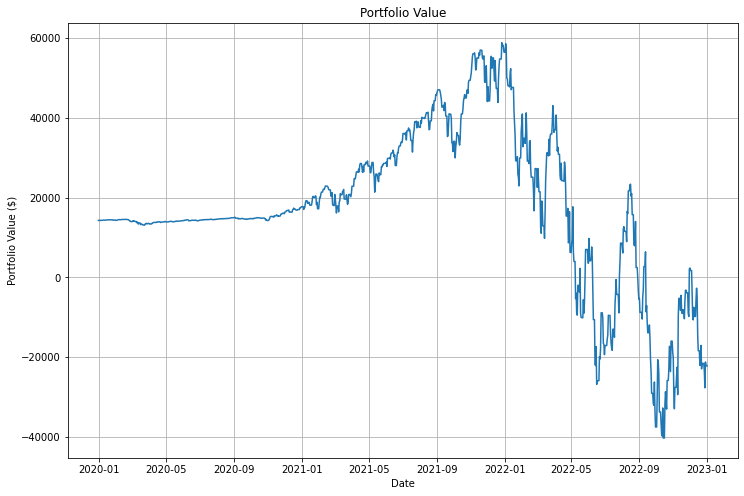

In [24]:
plt.figure(figsize=(12,8))
plt.plot(holdings_log.index, holdings_log["total_value"])
plt.title("Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid()
plt.savefig("cache/portfolio-value")
plt.show()